In [103]:
%load_ext autoreload
%autoreload 2
import sys
if "../" not in sys.path:
    sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from itertools import product
import time
import json
import os

from volterra_hawkes.iVi.iVi_hawkes import IVIHawkesProcess
from volterra_hawkes.kernel.kernels import *
from volterra_hawkes.utility.visualisation import Experiment, get_N_U_sample, get_arrivals_sample, plot_trajectories, plot_marginal_laws, poisson_jumps_test, plot_cf_convergence

from simulation.monte_carlo import MonteCarlo

from notebooks.numerical_tests import run_test2, run_test3

plt.style.use('seaborn-v0_8-deep')
plt.style.use('default')  # 'default' or any other light theme like 'seaborn-white'

color_cycle = ["#B56246", "#579F40", "#9A46B5", "#4699B5", "#B54662", "#D4A017", "#5b6c64", "#71074E", "#0033A0"]
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=color_cycle)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
SEED = 42
path_article = "images/article/"

# I. Gamma kernel

In [105]:
lam = 3
alpha = 2
experiment_gamma = Experiment(
    T=1,
    n_steps=1000,
    kernel=GammaKernel(lam=lam, alpha=alpha, c=0.9 * lam ** alpha),
    mu=5,
)

path_experiment = path_article + "gamma_kernel" + "/"
try:
    os.mkdir(path_experiment)
except FileExistsError as _:
    pass

### Sample paths

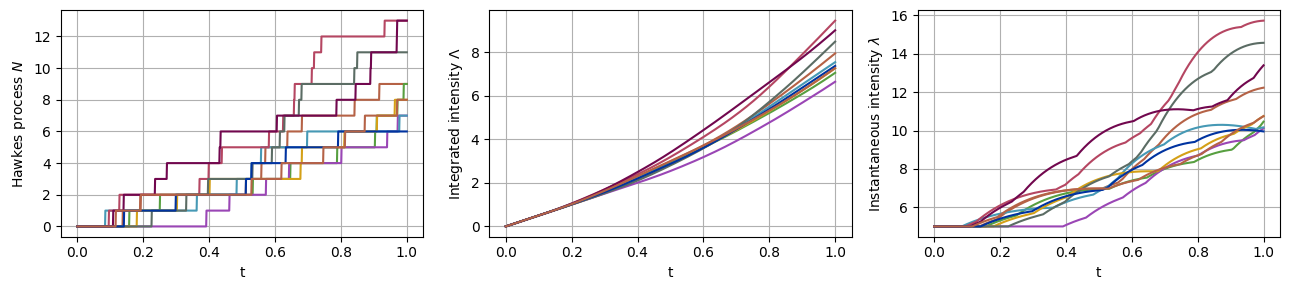

In [106]:
plot_trajectories(experiment_gamma, path=path_experiment + "gamma_sample_traj.pdf")

### Convergence of the Laplace transform

In [107]:
methods_non_ivi = ["Population", "Ogata"]
methods_ivi = ["iVi"] # "Res iVi"
n_paths_time_meas = 10**5
batch_size_cf = 10**5
n_batch_cf = 10
n_steps_arr_cf = [20, 35, 50, 65, 80, 100, 200, 350, 500, 750, 1000]
is_log_time = False

experiment_results = dict()
experiment_results["is_log_time"] = is_log_time
experiment_results["methods_ivi"] = methods_ivi
experiment_results["methods_non_ivi"] = methods_non_ivi
experiment_results["n_paths_time_meas"] = n_paths_time_meas
experiment_results["n_steps_arr_cf"] = n_steps_arr_cf
experiment_results["n_batch_cf"] = n_batch_cf
experiment_results["batch_size_cf"] = batch_size_cf

In [108]:
print("Pre-computing non-iVi samples...")
experiment_results["n_paths_non_ivi"] = 10_000
samples_non_ivi = {}
for method in methods_non_ivi:
    time_non_ivi = time.time()
    samples_non_ivi[method] = get_N_U_sample(experiment=experiment_gamma, method=method,
                                             n_paths=experiment_results["n_paths_non_ivi"],
                                             return_counters=True)
    time_non_ivi = time.time() - time_non_ivi
    experiment_results["time_" + method] = time_non_ivi * (experiment_results["n_paths_time_meas"] /
                                                           experiment_results["n_paths_non_ivi"])

Pre-computing non-iVi samples...


Computing iVi samples...
Mean: 7.37231604438123
iVi 20
iVi 35
iVi 50
iVi 65
iVi 80
iVi 100
iVi 200
iVi 350
iVi 500
iVi 750
iVi 1000


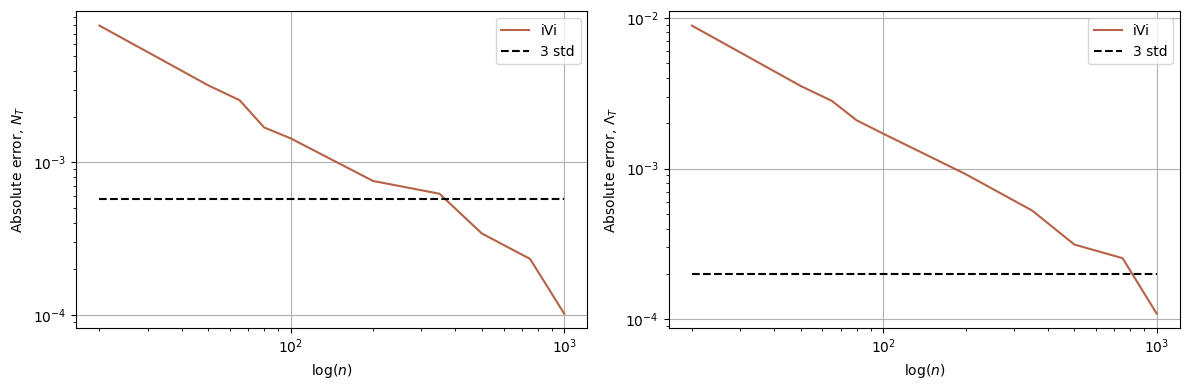

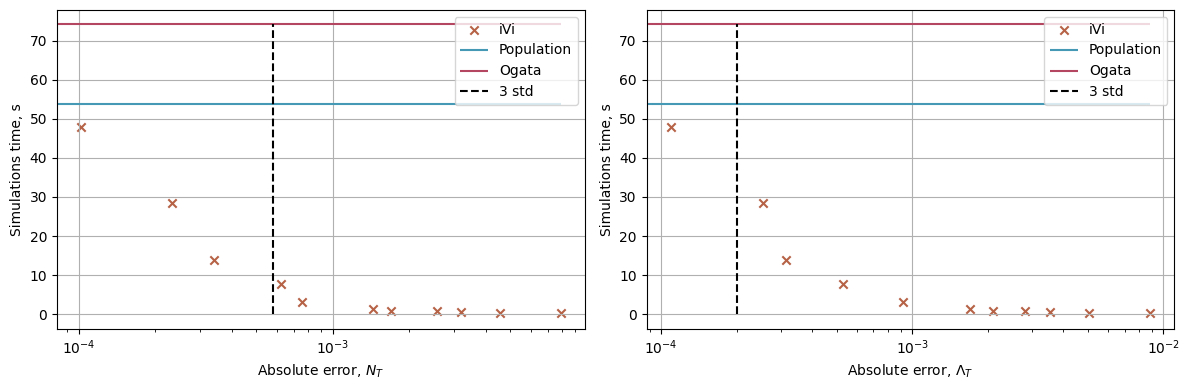

In [109]:
run_test3(experiment_gamma, path_experiment, experiment_results, samples_non_ivi)

with open(path_experiment + 'results_gamma.json', 'w') as f:
        json.dump(experiment_results, f)

### Plotting marginal laws

Computing iVi samples...
n_steps = 100
p-value Population-Ogata: 0.11890214798175557
p-value Population-iVi: 0.21692483428445863
p-value Population-Ogata: 0.031162582913927636
p-value Population-iVi: 0.22343759648123543


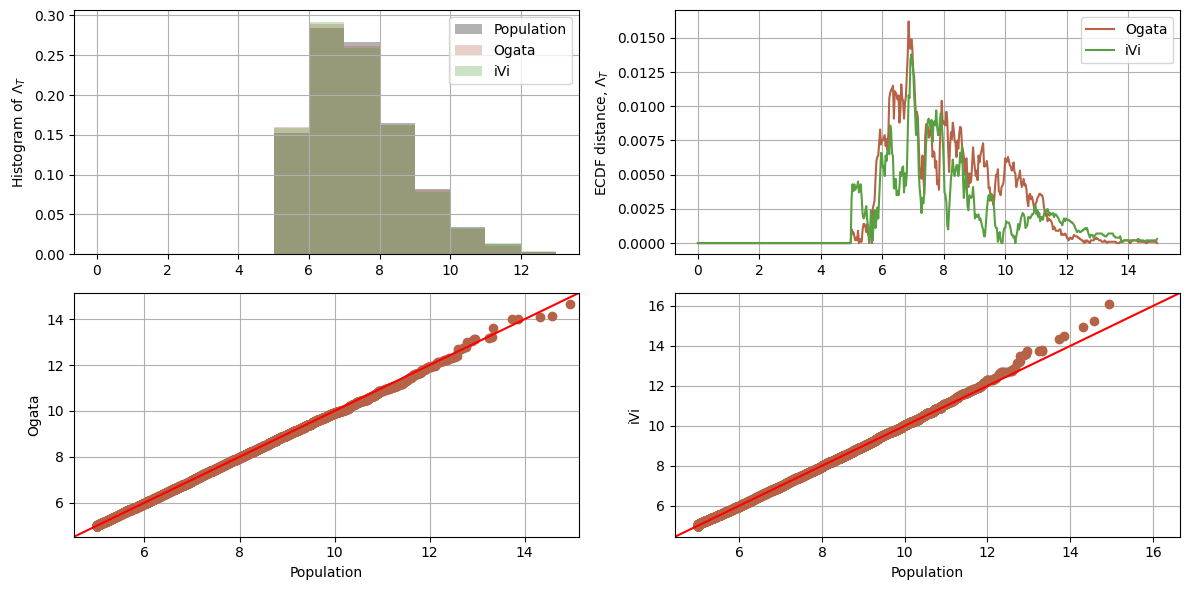

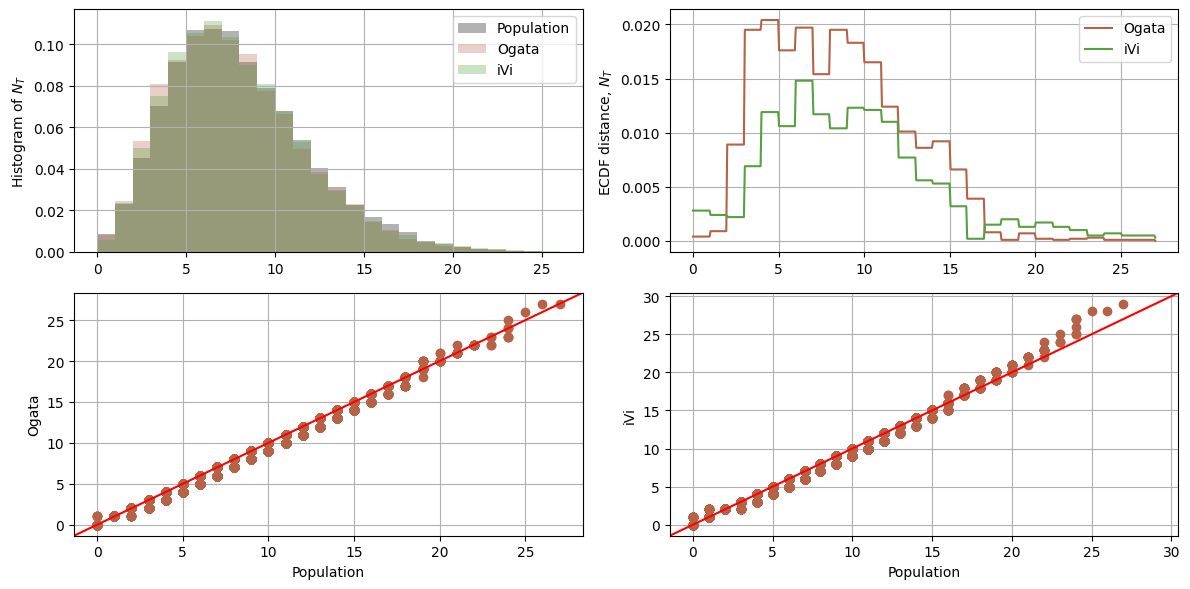

In [110]:
run_test2(experiment_gamma, path_experiment, experiment_results, samples_non_ivi)

with open(path_experiment + 'results_gamma.json', 'w') as f:
        json.dump(experiment_results, f)

### Simulation of arrival times

Population
Kolmogorov-Smirnov test p-value:  0.6898771332858613
Ogata
Kolmogorov-Smirnov test p-value:  0.25663392986954725
iVi
Kolmogorov-Smirnov test p-value:  0.4324032061886227


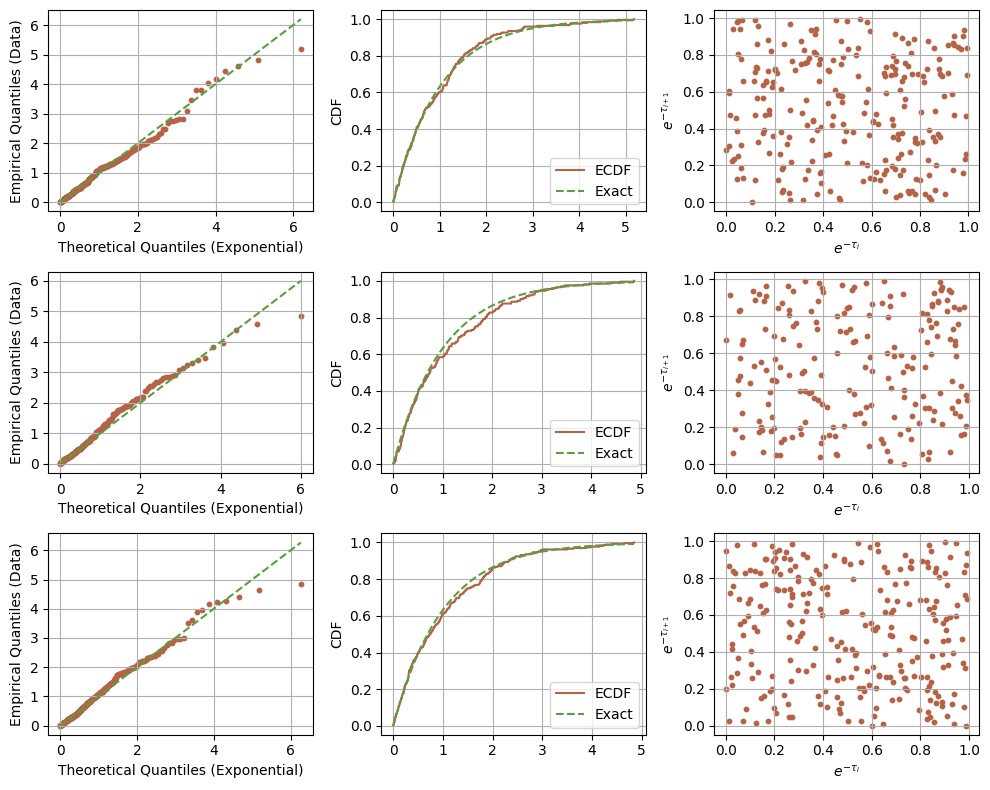

In [111]:
experiment_gamma_T10 = Experiment(
    T=10,
    n_steps=1000,
    kernel=GammaKernel(lam=lam, alpha=alpha, c=0.9 * lam ** alpha),
    mu=5,
)

methods = ["Population", "Ogata", "iVi"]

fig, axes = plt.subplots(3, 3, figsize=(10, 8))

for method, ax in zip(methods, axes):
    rng = np.random.default_rng(seed=SEED)
    samples_arrivals = get_arrivals_sample(experiment=experiment_gamma_T10, method=method, n_paths=1, rng=rng)
    print(method)
    ivi_hawkes = IVIHawkesProcess(kernel=experiment_gamma_T10.kernel, g0_bar=experiment_gamma_T10.g0_bar, rng=rng,
                                  g0=experiment_gamma_T10.g0, resolvent_flag=False)
    poisson_jumps_test(ivi_hawkes.U_from_jumps(samples_arrivals[0], samples_arrivals[0]), ax=ax, fig=fig,
                       path=path_experiment + "/arrivals_gamma.pdf")

# II. Fractional kernel

In [112]:
scale = 30
H = 0.1
c = 0.1
mu = 5

experiment_fractional = Experiment(
    T=1,
    n_steps = 1000,
    kernel = FractionalKernel(H=H, c=c * scale**(H + 0.5)),
    mu=mu * scale
)

path_experiment = path_article + "fractional_kernel" + "/"
try:
    os.mkdir(path_experiment)
except FileExistsError as _:
    pass

### Convergence of the Laplace transform

In [113]:
methods_non_ivi = ["Population", "Ogata"]
methods_ivi = ["iVi", "Res iVi"]
n_paths_time_meas = 10**5
batch_size_cf = 10**5
n_batch_cf = 10
n_steps_arr_cf = [20, 35, 50, 65, 80, 100, 200, 350, 500, 750, 1000]
is_log_time = True

experiment_results = dict()
experiment_results["is_log_time"] = is_log_time
experiment_results["methods_ivi"] = methods_ivi
experiment_results["methods_non_ivi"] = methods_non_ivi
experiment_results["n_paths_time_meas"] = n_paths_time_meas
experiment_results["n_steps_arr_cf"] = n_steps_arr_cf
experiment_results["n_batch_cf"] = n_batch_cf
experiment_results["batch_size_cf"] = batch_size_cf

In [114]:
print("Pre-computing non-iVi samples...")
experiment_results["n_paths_non_ivi"] = 10_000
samples_non_ivi = {}
for method in methods_non_ivi:
    time_non_ivi = time.time()
    samples_non_ivi[method] = get_N_U_sample(experiment=experiment_fractional, method=method,
                                             n_paths=experiment_results["n_paths_non_ivi"],
                                             return_counters=True)
    time_non_ivi = time.time() - time_non_ivi
    experiment_results["time_" + method] = time_non_ivi * (experiment_results["n_paths_time_meas"] /
                                                           experiment_results["n_paths_non_ivi"])

Pre-computing non-iVi samples...


Computing iVi samples...
Mean: 288.1422726513042
iVi 20
iVi 35
iVi 50
iVi 65
iVi 80
iVi 100
iVi 200
iVi 350
iVi 500
iVi 750
iVi 1000
Res iVi 20
Res iVi 35
Res iVi 50
Res iVi 65
Res iVi 80
Res iVi 100
Res iVi 200
Res iVi 350
Res iVi 500
Res iVi 750
Res iVi 1000


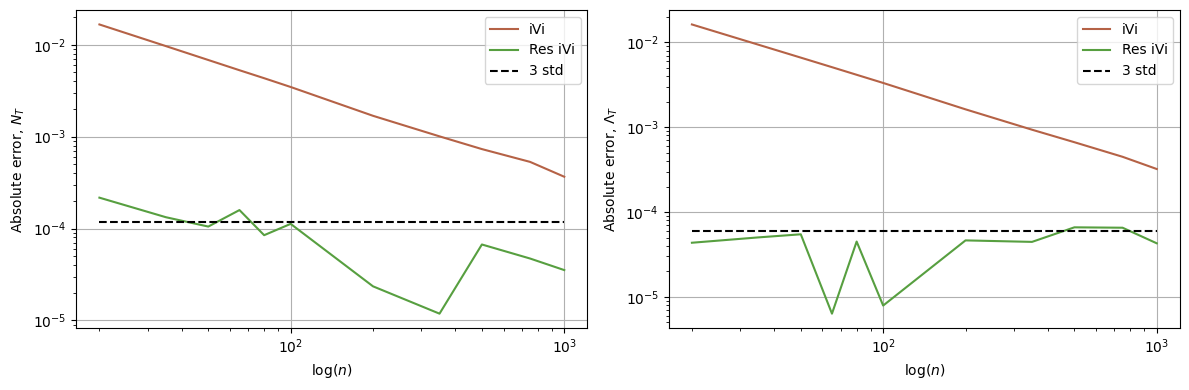

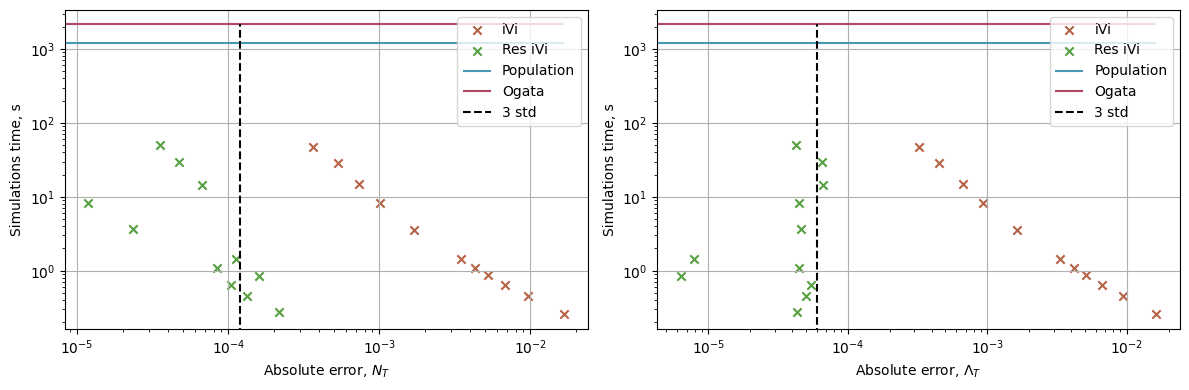

In [115]:
run_test3(experiment_fractional, path_experiment, experiment_results, samples_non_ivi)

with open(path_experiment + 'results_fractional.json', 'w') as f:
        json.dump(experiment_results, f)

# III. Exponential kernel

In [116]:
scaling = 2
c = 4
lam = 5
mu = 10

experiment_exponential = Experiment(
    T=1,
    n_steps = 1000,
    kernel = ExponentialKernel(c=c * scaling, lam=lam * scaling),
    mu=mu * scaling
)

path_experiment = path_article + "exponential_kernel" + "/"
try:
    os.mkdir(path_experiment)
except FileExistsError as _:
    pass

### Convergence of the Laplace transform

In [117]:
methods_non_ivi = ["ExpExact", "Ogata"]
methods_ivi = ["iVi", "Res iVi"]
n_paths_time_meas = 10**5
batch_size_cf = 10**5
n_batch_cf = 10
n_steps_arr_cf = [20, 35, 50, 65, 80, 100, 200, 350, 500, 750, 1000, 2000]
is_log_time = False

experiment_results = dict()
experiment_results["is_log_time"] = is_log_time
experiment_results["methods_ivi"] = methods_ivi
experiment_results["methods_non_ivi"] = methods_non_ivi
experiment_results["n_paths_time_meas"] = n_paths_time_meas
experiment_results["n_steps_arr_cf"] = n_steps_arr_cf
experiment_results["n_batch_cf"] = n_batch_cf
experiment_results["batch_size_cf"] = batch_size_cf

In [118]:
print("Pre-computing non-iVi samples...")
experiment_results["n_paths_non_ivi"] = 10_000
samples_non_ivi = {}
for method in methods_non_ivi:
    time_non_ivi = time.time()
    samples_non_ivi[method] = get_N_U_sample(experiment=experiment_exponential, method=method,
                                             n_paths=experiment_results["n_paths_non_ivi"],
                                             return_counters=True)
    time_non_ivi = time.time() - time_non_ivi
    experiment_results["time_" + method] = time_non_ivi * (experiment_results["n_paths_time_meas"] /
                                                           experiment_results["n_paths_non_ivi"])

Pre-computing non-iVi samples...


Computing iVi samples...
Mean: 65.33336952141568
iVi 20
iVi 35
iVi 50
iVi 65
iVi 80
iVi 100
iVi 200
iVi 350
iVi 500
iVi 750
iVi 1000
iVi 2000
Res iVi 20
Res iVi 35
Res iVi 50
Res iVi 65
Res iVi 80
Res iVi 100
Res iVi 200
Res iVi 350
Res iVi 500
Res iVi 750
Res iVi 1000
Res iVi 2000


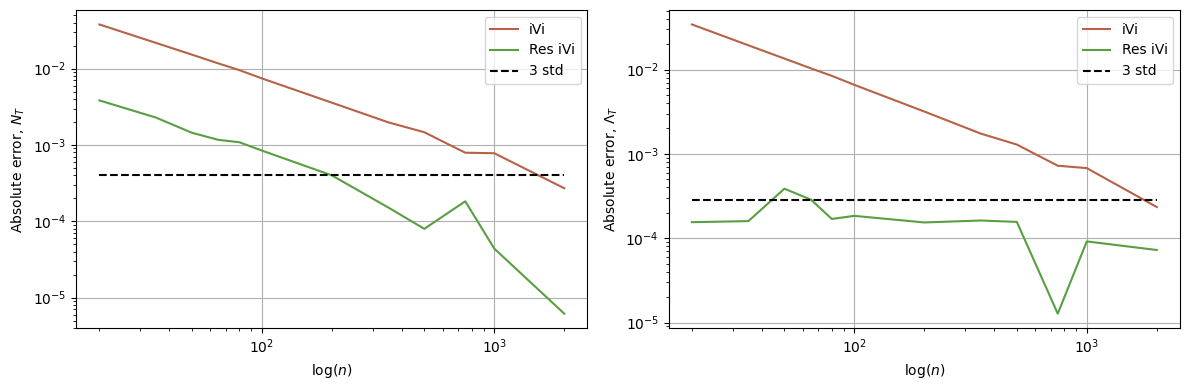

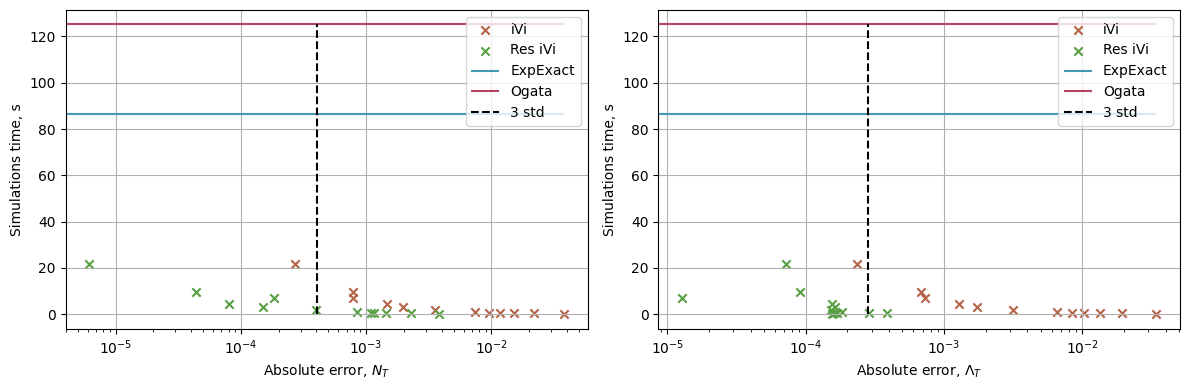

In [119]:
run_test3(experiment_exponential, path_experiment, experiment_results, samples_non_ivi)

with open(path_experiment + 'results_exponential.json', 'w') as f:
        json.dump(experiment_results, f)

In [121]:
experiment_results['time_ExpExact'] / experiment_results['time_Res iVi_200']

48.56941390384172

# Sanity check: $\mathbb{E}[N_T]$

In [7]:
lam_gamma_3 = 3
alpha_gamma_3 = 2
t0_gamma_3 = (alpha_gamma_3 - 1) / lam_gamma_3
gamma_kernel_3 = GammaKernel(lam=lam_gamma_3, alpha=alpha_gamma_3, c=0.9 * lam_gamma_3 ** alpha_gamma_3)

e=Experiment(
    T=1,
    n_steps=1000,
    kernel=gamma_kernel_3,
    mu=5,
    decreasing_kernel=lambda t: gamma_kernel_3(t) * (t > t0_gamma_3) + gamma_kernel_3(t0_gamma_3) * (t <= t0_gamma_3),
)

# I. Marginal Laws of $N_T$ and $U_T$

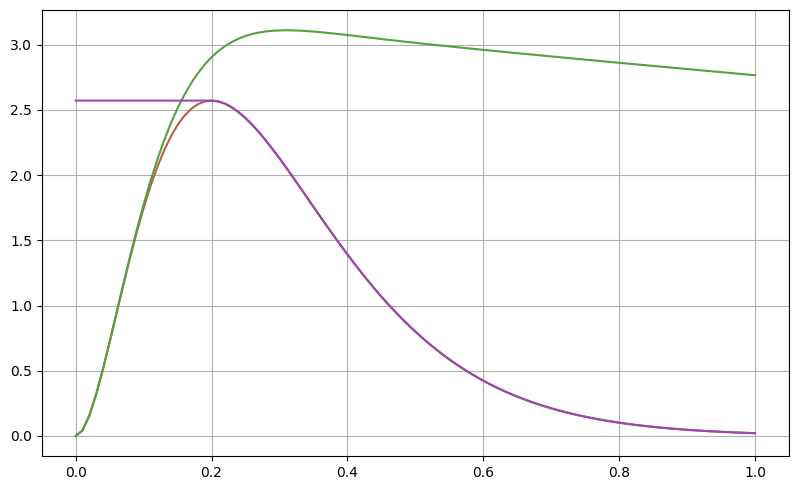

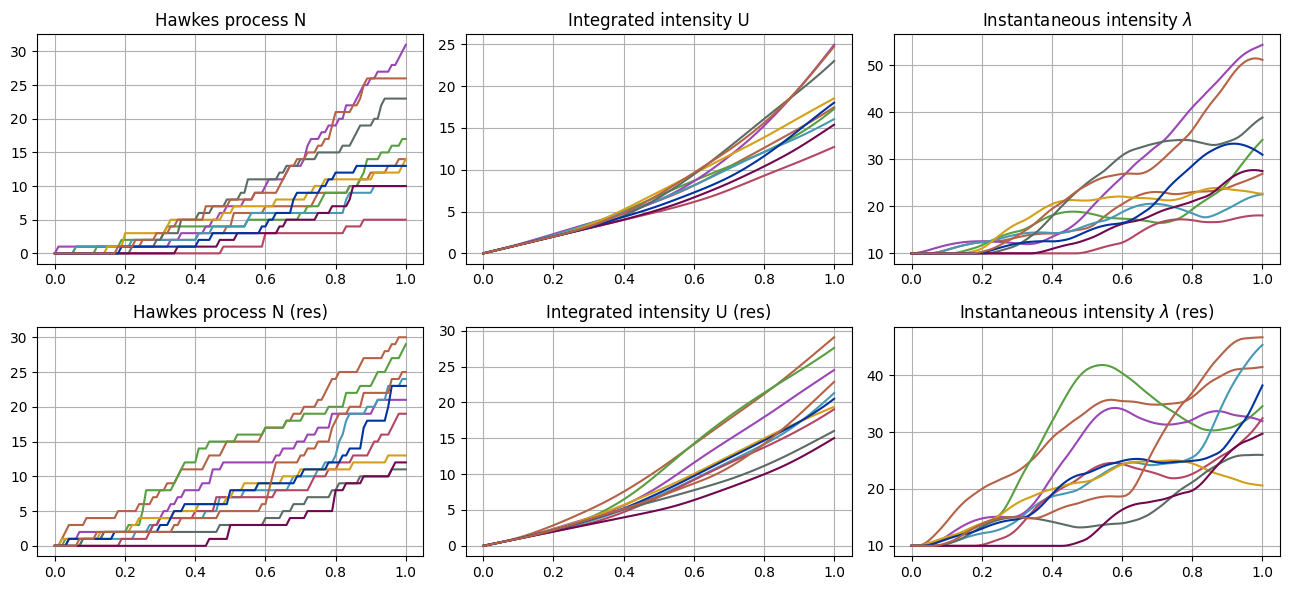

In [28]:
lam_gamma_2 = 10
alpha_gamma_2 = 3
t0_gamma_2 = (alpha_gamma_2 - 1) / lam_gamma_2
gamma_kernel_2 = GammaKernel(lam=lam_gamma_2, alpha=alpha_gamma_2, c=0.95 * lam_gamma_2 ** alpha_gamma_2)

e = Experiment(
    T=1,
    n_steps=100,
    kernel=gamma_kernel_2,
    mu=10,
    decreasing_kernel=lambda t: gamma_kernel_2(t) * (t > t0_gamma_2) + gamma_kernel_2(t0_gamma_2) * (t <= t0_gamma_2),
)

plt.plot(e.t_grid, e.kernel(e.t_grid))
plt.plot(e.t_grid, e.kernel.resolvent(e.t_grid))
plt.plot(e.t_grid, e.decreasing_kernel(e.t_grid))

plot_trajectories(e)

In [29]:
%%time

n_paths = 5_000

methods = ["Population", "Ogata", "iVi", "Res iVi"]
samples = {method: get_N_U_sample(experiment=e, method=method, n_paths=n_paths, return_counters=True) for method in methods}

CPU times: total: 7.72 s
Wall time: 8 s


p-value Population-Ogata: 0.6945834812298466
p-value Population-iVi: 0.43549127415019256
p-value Population-Res iVi: 0.1856663803254565


{'Population-Ogata': (0.6945834812298466, 0.0142),
 'Population-iVi': (0.43549127415019256, 0.0174),
 'Population-Res iVi': (0.1856663803254565, 0.0218)}

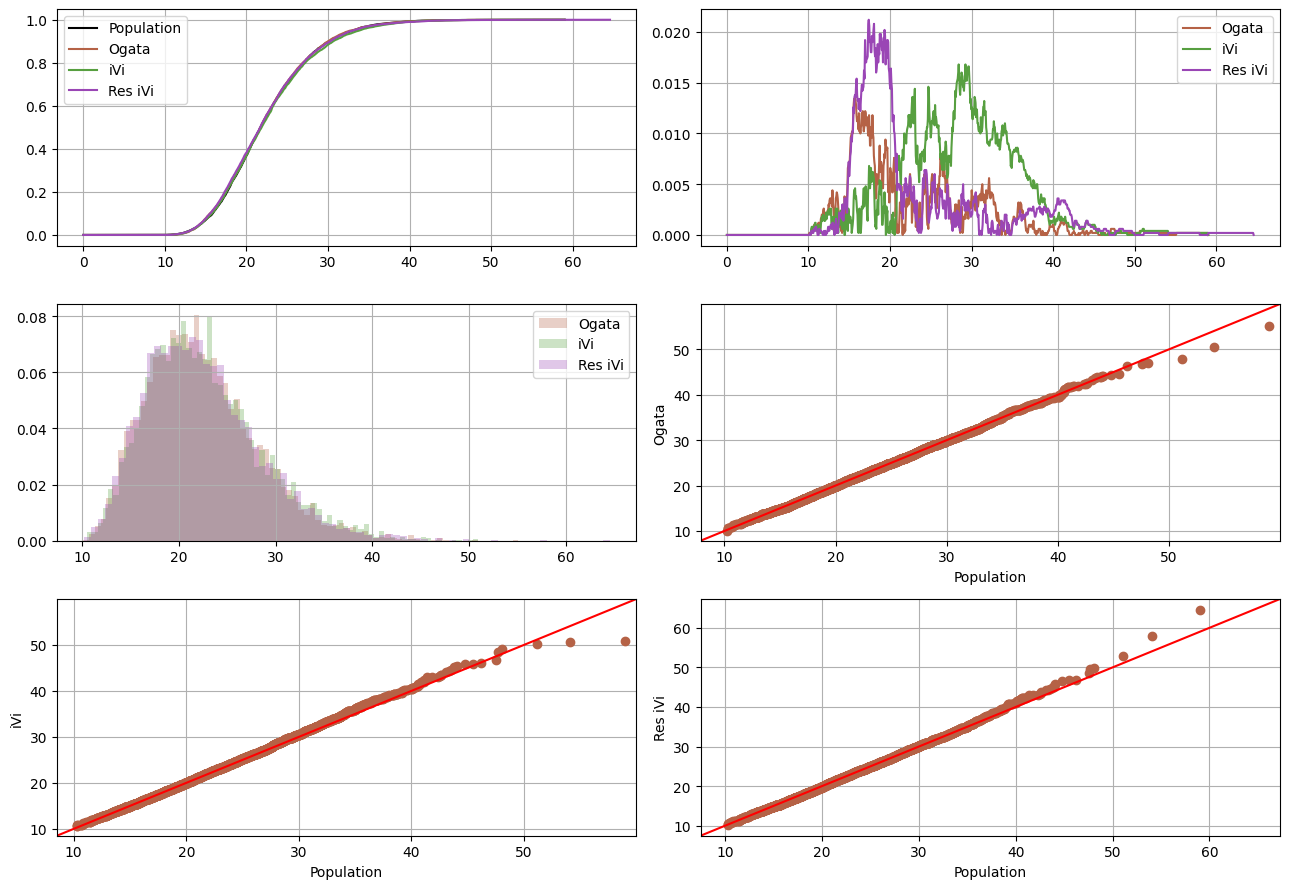

In [30]:
plot_marginal_laws(samples, "U")

p-value Population-Ogata: 0.10740980185915357
p-value Population-iVi: 0.0038596010962783566
p-value Population-Res iVi: 0.022340230544746754


{'Population-Ogata': (0.10740980185915357, 0.0171),
 'Population-iVi': (0.0038596010962783566, 0.025),
 'Population-Res iVi': (0.022340230544746754, 0.0212)}

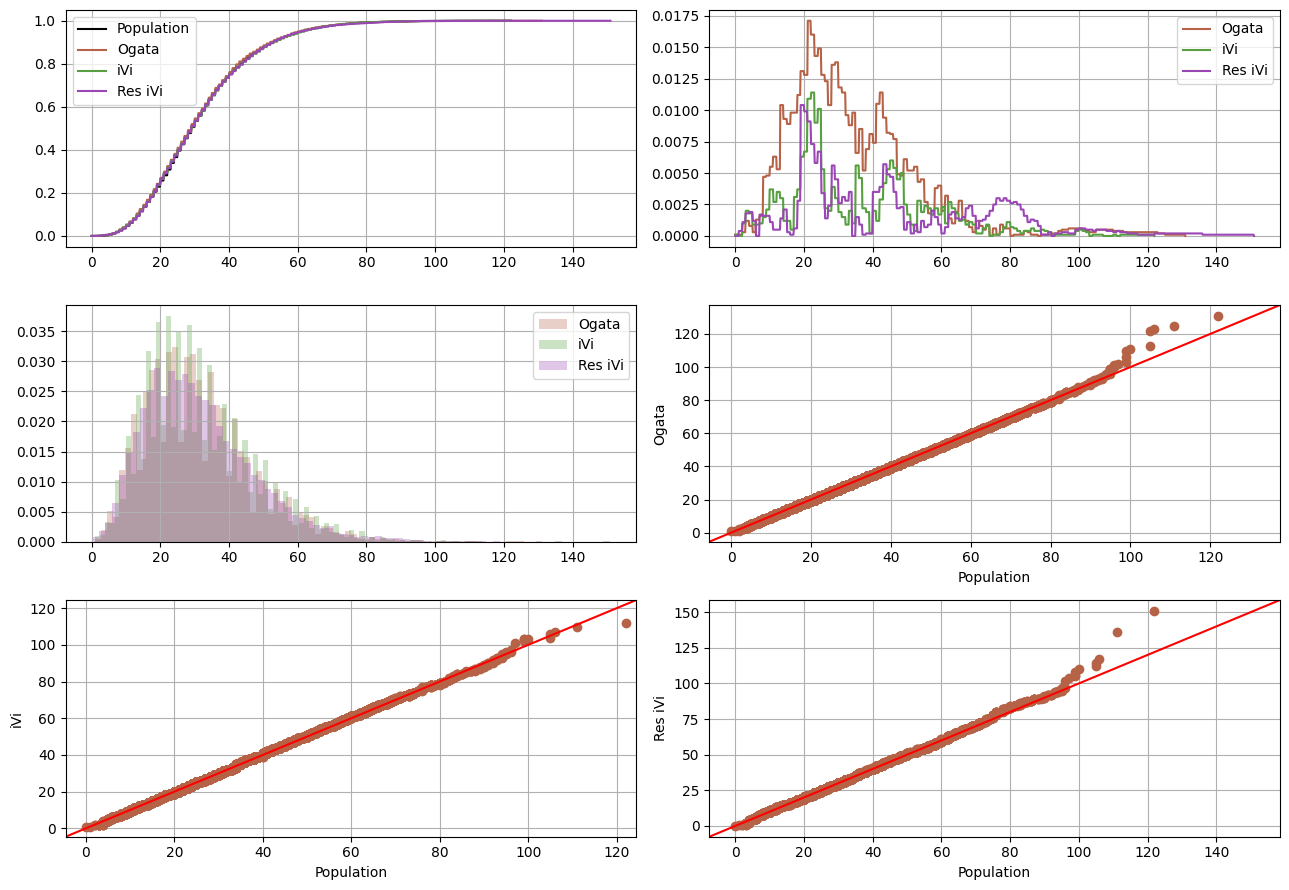

In [113]:
plot_marginal_laws(samples, "N")

p-value Population-Ogata: 0.734599370602186


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value Population-iVi: 0.9212790168134688


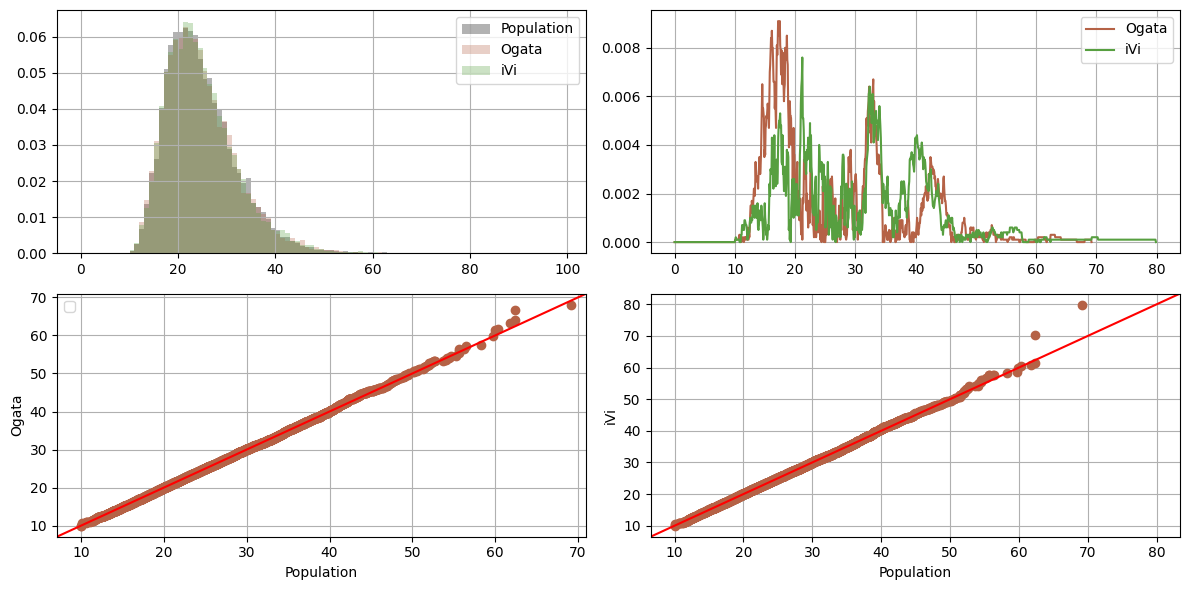

### Convergence rate

In [18]:
%%time

methods = ["iVi", "Res iVi"]
n_steps_arr = [20, 35, 50, 65, 80, 100, 200, 500, 750, 1000]
n_paths = 1_000_000

experiments = [e.change_n_steps(n_steps=n_steps) for n_steps in n_steps_arr]

# samples = {(method, e.n_steps): get_N_U_sample(experiment=e, method=method, n_paths=n_paths, return_counters=True) for method, e in product(methods, experiments)}

CPU times: total: 0 ns
Wall time: 0 ns


In [19]:
%%time
methods_non_ivi = ["Population", "Ogata"]
n_paths_non_ivi = 10_000
samples_non_ivi = {method: get_N_U_sample(experiment=experiments[-1], method=method, n_paths=n_paths_non_ivi, return_counters=True) for method in methods_non_ivi}

CPU times: total: 10.8 s
Wall time: 18.8 s


In [20]:
w = -1 / expected_N_T
fun = lambda x: np.exp(w * x)

cf_ref = {}

for mode in ["U", "N"]:
    idx = 1 if mode == "U" else 0

    rng = np.random.default_rng(seed=42)
    ivi = IVIHawkesProcess(kernel=experiments[-1].kernel, g0_bar=experiments[-1].g0_bar, rng=rng, g0=experiments[-1].g0, resolvent_flag=False)
    cf_ref[mode] = ivi.characteristic_function(T=experiments[-1].T, w=w, n_steps=10000, mode=mode)

In [25]:
mc_cf = {}
methods = ["iVi", "Res iVi"]
n_steps_arr = [20, 35, 50, 65, 80, 100, 200, 500, 750, 1000]
batch_size = 100_000
n_batch = 10
n_paths = n_batch * batch_size

experiments = [e.change_n_steps(n_steps=n_steps) for n_steps in n_steps_arr]
mc_samples = dict()

for method, experiment in product(methods, experiments):
    print(experiment.n_steps)
    rng = np.random.default_rng(seed=42)
    for _ in range(n_batch):
        sample = get_N_U_sample(experiment=experiment, method=method, n_paths=batch_size, rng=rng, return_counters=True)
        for mode in ["U", "N"]:
            idx = 1 if mode == "U" else 0
            if (method, experiment.n_steps, mode) not in mc_samples:
                mc_samples[(method, experiment.n_steps, mode)] = MonteCarlo(batch=fun(sample[idx][:, -1]), confidence_level=0.95)
            else:
                mc_samples[(method, experiment.n_steps, mode)].add_batch(batch=fun(sample[idx][:, -1]))

20
35
50
65
80
100
200
500
750
1000
20
35
50
65
80
100
200
500
750
1000


Reference value: 0.836485809483763
Reference value: 0.8383602684289374


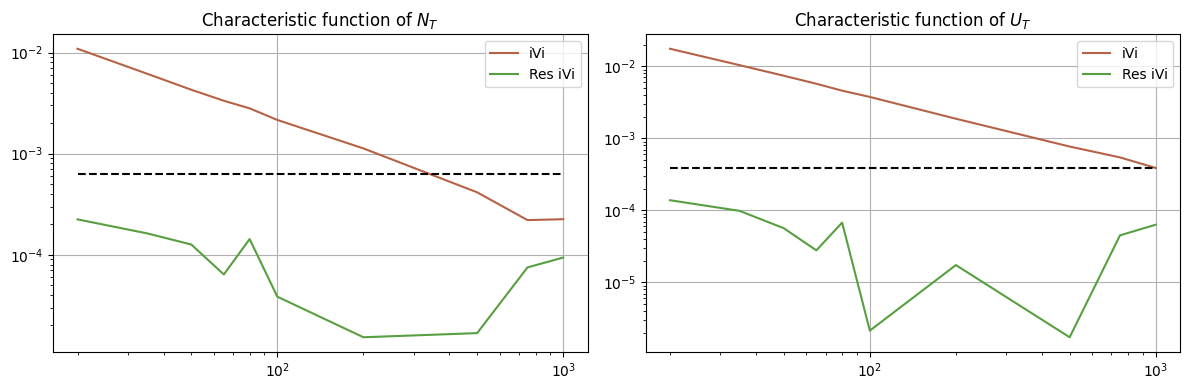

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

errors_ivi = {}
for mode in ["U", "N"]:
    idx = 1 if mode == "U" else 0
    print("Reference value:", cf_ref[mode])

    mc_std = np.sqrt(mc_samples[('Res iVi', n_steps_arr[-1], mode)].var / n_paths)

    errors_ivi[mode] = {}
    methods = ["iVi", "Res iVi"]

    for method in methods:
        errors_ivi[mode][method]  = []
        for experiment in experiments:
            # U = samples[(method, e.n_steps)][idx]
            errors_ivi[mode][method].append(np.abs(cf_ref[mode] - mc_samples[(method, experiment.n_steps, mode)].mean))
        ax[idx].loglog(n_steps_arr, errors_ivi[mode][method], label=method)
    ax[idx].hlines(y=3 * mc_std, xmin=n_steps_arr[0], xmax=n_steps_arr[-1], color="k", linestyles="--")
    ax[idx].set_title(f"Characteristic function of ${mode}_T$")
    ax[idx].legend()

# II. Distribution of arriavals

## Simulation of arrivals

Population
Kolmogorov-Smirnov test p-value:  0.14289882224580774
Ogata
Kolmogorov-Smirnov test p-value:  0.5329244487250036
iVi
Kolmogorov-Smirnov test p-value:  0.8097022049731294


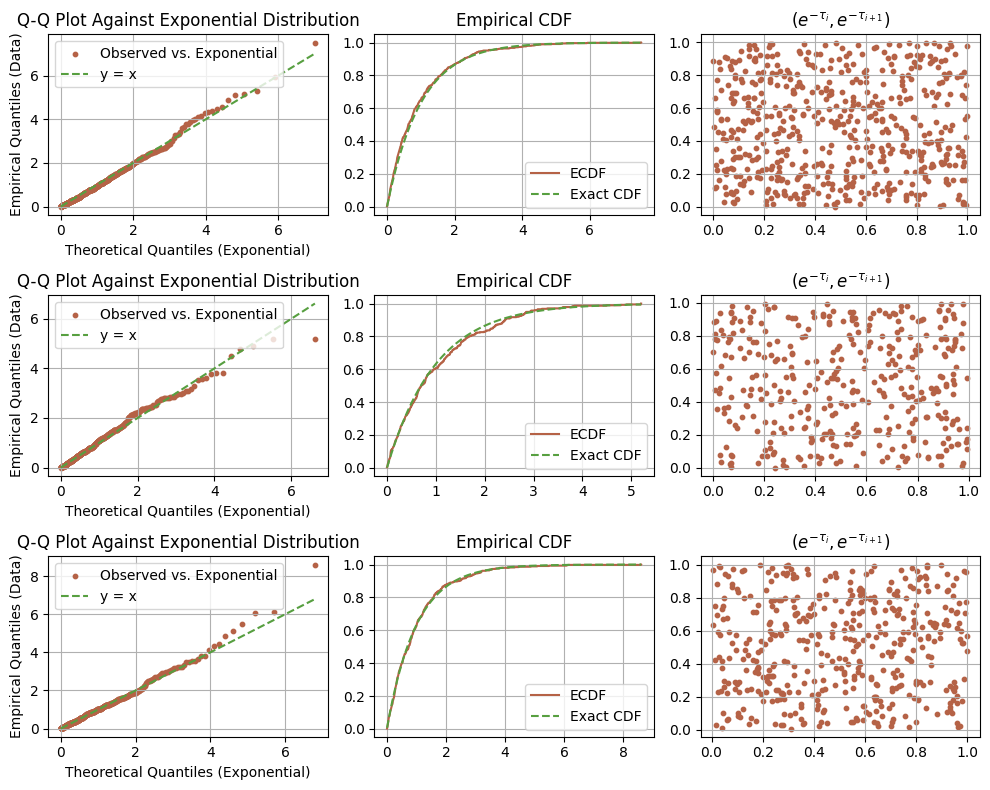

Gamma kernel

In [4]:
import json

with open('../experiments/Experiment(T=1, n_steps=1000, kernel=GammaKernel(alpha=2, lam=3, c=8.1), mu=5)_2025-08-28_10_09_30/results.json') as f:
    results = json.load(f)
    print(results)

{'methods_ivi': ['iVi'], 'methods_non_ivi': ['Population', 'Ogata'], 'n_paths_time_meas': 100000, 'n_steps_arr_cf': [20, 35, 50, 65, 80, 100, 200, 350, 500, 750, 1000], 'n_batch_cf': 10, 'batch_size_cf': 100000, 'n_paths_non_ivi': 10000, 'time_Population': 84.45497035980225, 'time_Ogata': 91.36264324188232, 'mean_N_T': 7.37231604438123, 'U_p_values_10': {'Population-Ogata': [0.11890214798175557, 0.0168], 'Population-iVi': [1.5282513643318188e-42, 0.0984]}, 'N_p_values_10': {'Population-Ogata': [0.031162582913927636, 0.0204], 'Population-iVi': [1.044038376030117e-22, 0.0716]}, 'U_p_values_50': {'Population-Ogata': [0.11890214798175557, 0.0168], 'Population-iVi': [0.014473851205715274, 0.0222]}, 'N_p_values_50': {'Population-Ogata': [0.031162582913927636, 0.0204], 'Population-iVi': [4.585036479758856e-26, 0.0768]}, 'U_p_values_100': {'Population-Ogata': [0.11890214798175557, 0.0168], 'Population-iVi': [0.21692483428445863, 0.0149]}, 'N_p_values_100': {'Population-Ogata': [0.0311625829139

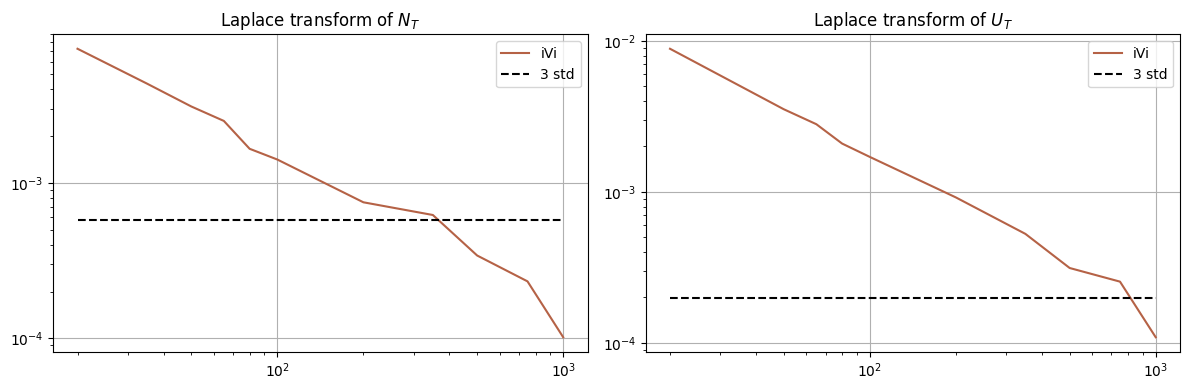

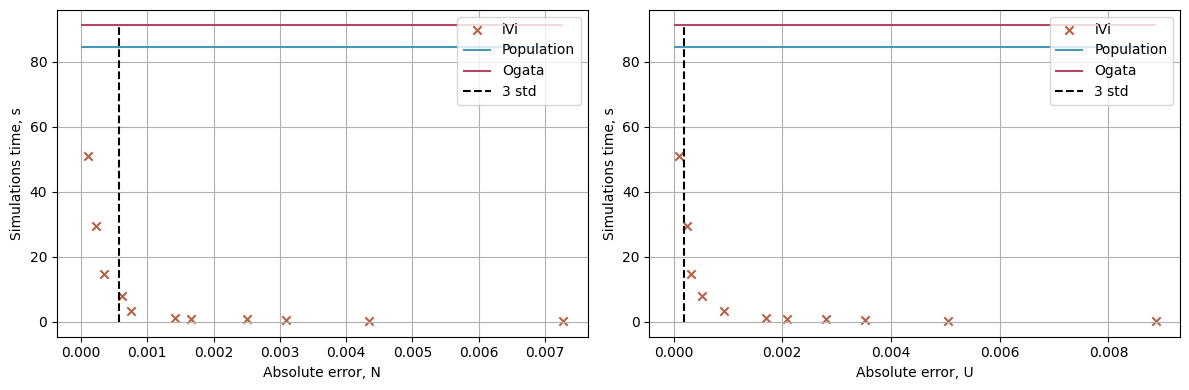

In [6]:
plot_cf_convergence(results=results, path_experiment="./gamma_article/")

In [26]:
%%time

n_paths = 10_000

e = Experiment(T=1, n_steps=100, kernel=GammaKernel(alpha=2, lam=3, c=8.1), mu=5)

methods = ["Population", "Ogata", "iVi", "Res iVi"]
samples = {method: get_N_U_sample(experiment=e, method=method, n_paths=n_paths, return_counters=True) for method in methods}

CPU times: total: 6.53 s
Wall time: 7.16 s


zz## Fractional

In [31]:
import json

with open('../experiments/Experiment(T=1, n_steps=1000, kernel=FractionalKernel(c=0.7696136340726079, H=0.1), mu=150)_2025-08-27_05_55_03_full_res_million/results.json') as f:
    results = json.load(f)
    print(results)

{'methods_ivi': ['iVi', 'Res iVi'], 'methods_non_ivi': ['Population', 'Ogata'], 'n_paths_time_meas': 100000, 'n_paths_non_ivi': 10000, 'time_Population': 1179.8014450073242, 'time_Ogata': 2175.1196026802063, 'mean_N_T': 288.1422726513042, 'U_p_values_10': {'Population-Ogata': [0.6160853764303585, 0.0107], 'Population-iVi': [0.0, 0.5907], 'Population-Res iVi': [0.42554664596413133, 0.0124]}, 'N_p_values_10': {'Population-Ogata': [0.31338762324335184, 0.0136], 'Population-iVi': [1e-323, 0.3279], 'Population-Res iVi': [0.1449137168873294, 0.0162]}, 'U_p_values_50': {'Population-Ogata': [0.6160853764303585, 0.0107], 'Population-iVi': [2.7391559486243423e-88, 0.142], 'Population-Res iVi': [0.5342696653345376, 0.0114]}, 'N_p_values_50': {'Population-Ogata': [0.31338762324335184, 0.0136], 'Population-iVi': [4.664971860248842e-21, 0.0689], 'Population-Res iVi': [0.175326677835407, 0.0156]}, 'U_p_values_100': {'Population-Ogata': [0.6160853764303585, 0.0107], 'Population-iVi': [8.71093747381464

In [36]:
results['time_Population'] / results['time_Res iVi_20']

4238.986647967007

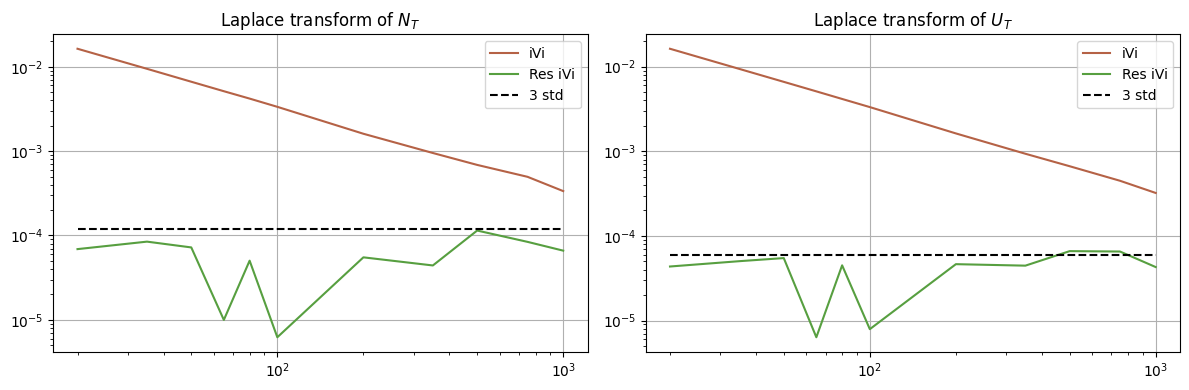

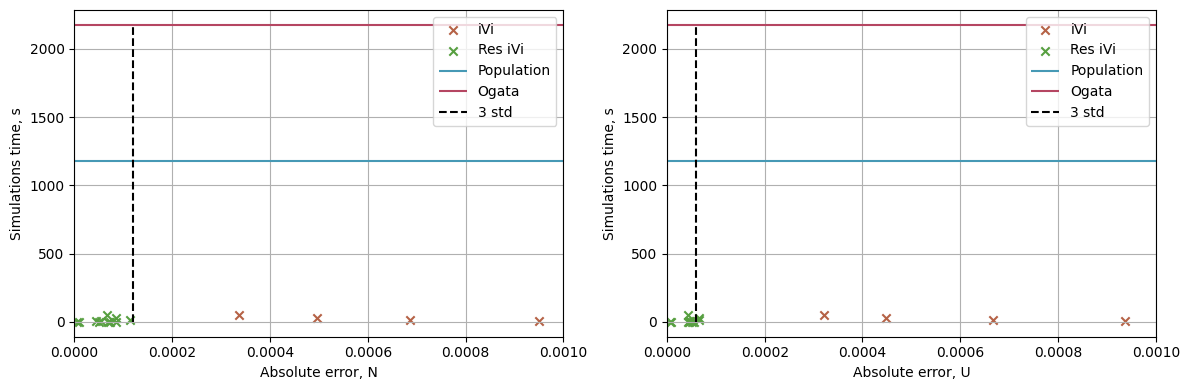

In [34]:
plot_cf_convergence(results=results, path_experiment="./fractional_article/", x_lim=[0, 0.001])

## Exponential

In [37]:
import json

with open('../experiments/Experiment(T=1, n_steps=1000, kernel=ExponentialKernel(c=8, lam=10), mu=20)_2025-08-27_20_02_44_exp_2000_steps/results.json') as f:
    results = json.load(f)
    print(results)

{'methods_ivi': ['iVi', 'Res iVi'], 'methods_non_ivi': ['ExpExact', 'Ogata'], 'n_paths_time_meas': 100000, 'n_steps_arr_cf': [20, 35, 50, 65, 80, 100, 200, 350, 500, 750, 1000, 2000], 'n_batch_cf': 10, 'batch_size_cf': 100000, 'n_paths_non_ivi': 10000, 'time_ExpExact': 157.00987339019775, 'time_Ogata': 237.8031039237976, 'mean_N_T': 65.33336952141568, 'U_p_values_10': {'ExpExact-Ogata': [0.7229401381401557, 0.0098], 'ExpExact-iVi': [1e-323, 0.2907], 'ExpExact-Res iVi': [0.04126178292409227, 0.0197]}, 'N_p_values_10': {'ExpExact-Ogata': [0.6398931694241892, 0.0105], 'ExpExact-iVi': [9.610020744831768e-203, 0.215], 'ExpExact-Res iVi': [0.01512953257863315, 0.0221]}, 'U_p_values_50': {'ExpExact-Ogata': [0.7229401381401557, 0.0098], 'ExpExact-iVi': [3.603088566507035e-18, 0.0639], 'ExpExact-Res iVi': [0.31338762324335184, 0.0136]}, 'N_p_values_50': {'ExpExact-Ogata': [0.6398931694241892, 0.0105], 'ExpExact-iVi': [3.7805627315956485e-14, 0.0562], 'ExpExact-Res iVi': [0.042915742476880514, 0

In [38]:
results['time_ExpExact'] / results['time_Res iVi_20']

561.0341816170651

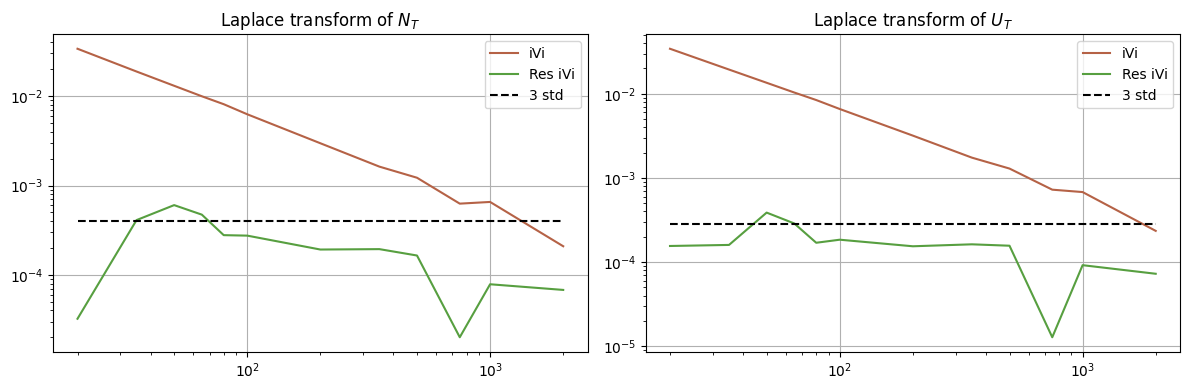

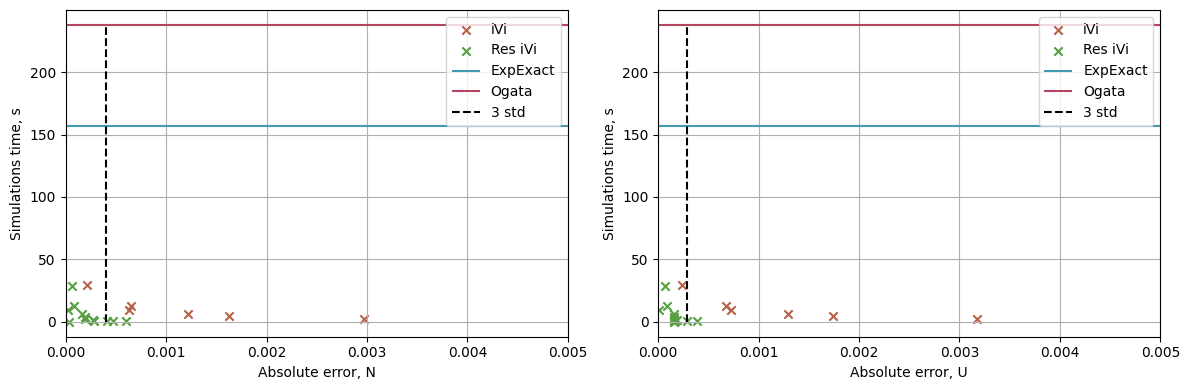

In [40]:
plot_cf_convergence(results=results, path_experiment="./exponential_article/", x_lim=[0, 0.005])